# UNet
A UNet consists of both encoder and decoder layers connected by skip connections, which allow information to flow freely between the two. 
Unets are often used for image-to-image tasks, such as image segmentation. Each pixel in an image is converted to another property that is more appropriate for analysis.

## The ssTEM dataset

We will segment different neuronal structures in serial section Transmission Electron Microscopy (ssTEM) images of the ventral nerve cord of the Drosophila melanogaster, a fruit fly. 
The dataset consists of 20 ssTEM images, whose size is 1024 x 1024 pixels. In addition to the ssTEM images, the dataset also contains ground-truth segmentations of the neuronal structures. 
For simplicity, we will only consider the segmentation of the neuronal intracellular regions and mitochondria.

In [1]:
import os

if not os.path.exists("groundtruth-drosophila-vnc"):
    os.system("git clone https://github.com/unidesigner/groundtruth-drosophila-vnc")

raw_path = os.path.join("groundtruth-drosophila-vnc", "stack1", "raw")
label_path = os.path.join("groundtruth-drosophila-vnc", "stack1", "labels")

train_images_paths = os.listdir(raw_path)

print(f"{len(train_images_paths)} training images")

Cloning into 'groundtruth-drosophila-vnc'...


20 training images


We define the data paths for the loaders.

In [2]:
import deeptrack as dt
import torch

dt.config.disable_image_wrapper()

raw_paths = dt.sources.ImageFolder(root=raw_path)
label_paths = dt.sources.ImageFolder(root=label_path)

paths = dt.sources.Source(raw=raw_paths, label=label_paths)
train_paths, test_paths = dt.sources.random_split(paths, [0.9, 0.1])

train_sources = train_paths.product(
    flip_ud=[True, False],
    flip_lr=[True, False],
    crop=[0, 1, 2],
    should_crop=[True],
)

test_sources = test_paths.constants(
    flip_ud=False,
    flip_lr=False,
    should_crop=False,
)

sources = dt.sources.Sources(train_sources, test_sources)

2024-01-31 20:29:34.936303: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


We will use a function to select only the labels of the cell structures we are interested in, i.e. neuronal intracellular regions and mitochondria.

In [3]:
import numpy as np


def select_labels(class_labels=None):
    def inner(gt_seg_image):
        gt_seg_image = gt_seg_image.copy()
        masked_gt_seg_imag = gt_seg_image * np.isin(gt_seg_image, class_labels).astype(
            np.uint8
        )
        replace = np.arange(len(class_labels)) + 1
        gt_seg_image_new_labels = np.select(
            [masked_gt_seg_imag == cl for cl in class_labels], replace
        ).astype(np.uint8)
        out = np.eye(len(class_labels) + 1)[gt_seg_image_new_labels.squeeze()]

        return out

    return inner

We define the pipeline to load, crop, and augment the images.

In [4]:
im_pipeline = dt.LoadImage(sources.raw.path) >> dt.NormalizeMinMax()
lab_pipeline = dt.LoadImage(sources.label.path) >> dt.Lambda(
    select_labels, class_labels=[255, 191]
)

pipeline = (
    (im_pipeline & lab_pipeline)
    >> dt.FlipLR(sources.flip_lr)
    >> dt.FlipUD(sources.flip_ud)
    >> dt.ConditionalSetFeature(
        on_true=dt.Crop(crop=(256, 256, None)), condition=sources.should_crop
    )
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

We create train and test datasets and display a few image crops with the corresponding segmentation. 

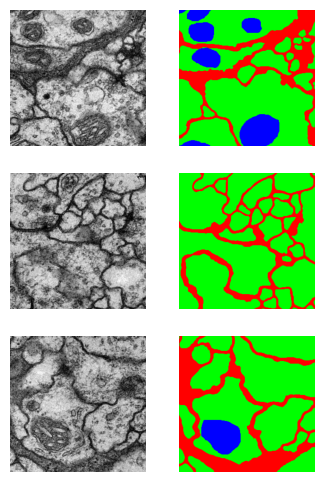

In [5]:
import matplotlib.pyplot as plt

train_dataset = dt.pytorch.Dataset(pipeline, train_sources)
test_dataset = dt.pytorch.Dataset(pipeline, test_sources)

fig, axs = plt.subplots(3, 2, figsize=((4, 6)))
for i in range(3):
    image, label = train_dataset[i]
    axs[i, 0].imshow(image.permute(1, 2, 0), cmap="gray")
    axs[i, 0].set_axis_off()
    axs[i, 1].imshow(label.permute(1, 2, 0), cmap="gray")
    axs[i, 1].set_axis_off()

We define the dataloaders...

In [6]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

... and the UNet

In [7]:
import deeplay as dl
from torch.nn import Identity
from torch.nn import CrossEntropyLoss


unet = dl.UNet2d(
    in_channels=1,
    channels=[16, 32, 64, 128],
    out_channels=3,
)

unet_regressor = dl.Regressor(
    model=unet,
    loss=CrossEntropyLoss(),
    optimizer=dl.Adam(),
).create()

print(unet)

UNet2d(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Layer[Identity]()
        (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=16)
      )
      (1): PoolLayerActivationNormalization(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=32)
      )
      (2): PoolLayerActivationNormalization(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=64)
      )
      (3): PoolLayerActivationNormalization(
        (pool):

We train it for 50 epochs

In [8]:
unet_trainer = dl.Trainer(max_epochs=50, accelerator="auto")
unet_trainer.fit(unet_regressor, train_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:452: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
INFO: 
  | Name          | Type             | Params

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


## Evaluation

We apply the UNet to the test set 

In [9]:
images, labels, preds = [], [], []

for im, lab in test_loader:
    images.append(im)
    labels.append(lab)
    pr = unet_regressor(im).detach()
    pr = torch.nn.functional.softmax(pr, dim=1)
    preds.append(pr)
images = torch.cat(images, dim=0).squeeze()
labels = torch.cat(labels, dim=0).argmax(axis=1)
preds = torch.cat(preds, dim=0).argmax(axis=1)

We calculate the Jaccard Index, a.k.a. Intersection over Union (IoU) as a metrics to evaluate the results.

In [10]:
from torchmetrics import JaccardIndex

JI = JaccardIndex(task="multiclass", num_classes=3)
ji = [JI(p, l) for p, l in zip(preds, labels)]

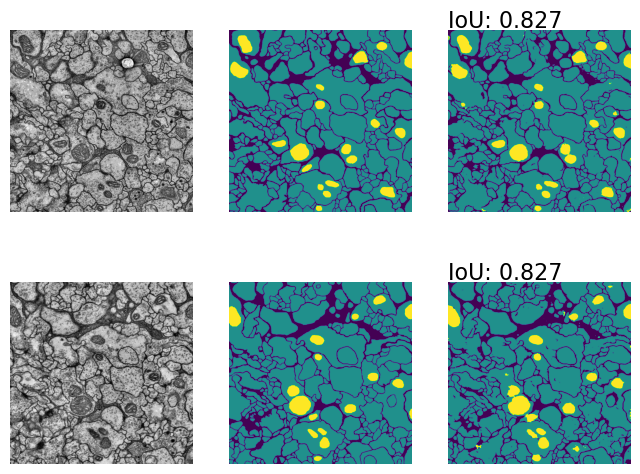

In [12]:
fig, axs = plt.subplots(2, 3, figsize=((8, 6)))
for i in range(2):
    image = images[i]
    label = labels[i]
    pred = preds[i]
    axs[i, 0].imshow(image, cmap="gray")
    axs[i, 0].set_axis_off()
    axs[i, 1].imshow(label)
    axs[i, 1].set_axis_off()
    axs[i, 2].imshow(pred)
    axs[i, 2].text(0, -10, f"IoU: {ji[i].numpy():.3f}", fontsize=16)
    axs[i, 2].set_axis_off()